In [2]:
# !pip install bambi
# !pip install preliz
# !pip install numpyro
# !pip install jax
# !pip install jaxlib

In [1]:
import pymc as pm
import seaborn as sns
# import bambi as bmb
# import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# import preliz as pz
import arviz as az
import os
import numpy as np
import pytensor  
import gzip
# import jax
# import numpyro
import pickle
import cloudpickle
# import blackjax
# import nutpie
import gdown
import tempfile
# pytensor.config.floatX = "float32"

In [2]:
pytensor.config.cxx = '/usr/bin/clang++'

In [2]:
file_id = "1P2-DrRmHUoO7d8lmZ480xrmbrGuxpCoI"
url = f"https://drive.google.com/uc?id={file_id}"

try:
    with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tmp:
        tmp_path = tmp.name

    gdown.download(url, tmp_path, quiet=False)

    df = pd.read_pickle(tmp_path)
except Exception as e:
    print("No data on g-drive")

Downloading...
From: https://drive.google.com/uc?id=1P2-DrRmHUoO7d8lmZ480xrmbrGuxpCoI
To: C:\Users\kugor\AppData\Local\Temp\tmp3qgij0sh.csv
100%|██████████| 24.4M/24.4M [00:02<00:00, 9.26MB/s]


In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_pickle('/content/drive/MyDrive/data_resampled.csv')
    print("Data loaded from Google Drive.")
except Exception as e:
    print("No data")

In [ ]:
try:
  df = pd.read_pickle("../data/interim/data_resampled.csv")
except:
  print("no data in colab session")

In [24]:
###### SAMPLE 30k ROWS ##########
file_id = "13HsgCri_zp1USVP2fYmMOWPx0SALzReM"
url = f"https://drive.google.com/uc?id={file_id}"

try:
    with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tmp:
        tmp_path = tmp.name

    gdown.download(url, tmp_path, quiet=False)

    df = pd.read_pickle(tmp_path)
except Exception as e:
    print("No data on g-drive")

Downloading...
From: https://drive.google.com/uc?id=13HsgCri_zp1USVP2fYmMOWPx0SALzReM
To: /var/folders/q0/67njxxl578sd7zccjj5dk9_40000gq/T/tmp9hh_b7de.csv
100%|████████████████████████████████████| 2.45M/2.45M [00:00<00:00, 11.5MB/s]


In [3]:
df["stress"] = df["label"].replace({
    "Brak stresu": 0,
    "Niski/Średni": 1,
    "Wysoki": 2
})

C:\Users\kugor\AppData\Local\Temp\ipykernel_11844\3318738806.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["stress"] = df["label"].replace({


In [4]:
cat_nurse = pd.Categorical(df['id'])
df["nurse_idx"] = cat_nurse.codes
n_nurses = len(cat_nurse.categories)
coords = {"nurse": cat_nurse.categories,
          "stress": ["Niski/Średni", "Wysoki"]}
stress = df["stress"].values
nurse_idx = df["nurse_idx"].values
temp = df["TEMP"].values
df=pd.concat([pd.get_dummies(df, columns=["label"], dtype="int32", drop_first=True), df['label']], axis=1)

In [6]:
pz.Normal(mu=df["TEMP"].mean(), sigma=10).plot_pdf()
pz.Exponential(0.1).plot_pdf()

NameError: name 'pz' is not defined

In [43]:
df

,id,X,Y,Z,EDA,HR,TEMP,stress,nurse_idx,label_Niski/Średni,label_Wysoki,label
datetime,,,,,,,,,,,,
2020-04-14 22:31:00,5C,-21.993750,-43.437500,127.00000,22.103413,82.316,36.500,1,1,1,0,Niski/Średni
2020-04-14 22:31:10,5C,-22.018750,-43.400000,127.00000,22.298288,81.118,36.499,1,1,1,0,Niski/Średni
2020-04-14 22:31:20,5C,-22.028125,-43.534375,127.00000,22.046580,80.156,36.495,1,1,1,0,Niski/Średni
2020-04-14 22:31:30,5C,-22.056250,-43.303125,127.00000,21.413281,79.878,36.497,1,1,1,0,Niski/Średni
2020-04-14 22:31:40,5C,-22.075000,-43.381250,127.00000,21.335523,79.831,36.488,1,1,1,0,Niski/Średni
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-13 08:00:20,83,-30.862500,4.712500,52.26250,5.573162,70.637,33.950,2,6,0,1,Wysoki
2020-12-13 08:00:30,83,-35.256250,9.278125,42.05625,5.236739,70.649,33.973,2,6,0,1,Wysoki
2020-12-13 08:00:40,83,-47.475000,3.806250,42.31250,5.040609,70.616,33.966,2,6,0,1,Wysoki


#### Unpooled model, fitting a normal distribution for TEMP variable

In [ ]:
# Trying non-pooled model first
with pm.Model(coords=coords) as unpooled_model:
    # priors
    mu = pm.Normal("mu", mu=df["TEMP"].mean(), sigma=1, dims="nurse")
    sigma=pm.Exponential("sigma", 0.1, dims="nurse")
    # likelihood
    y_temp = pm.Normal("y_temp", mu=mu[nurse_idx], sigma=sigma[nurse_idx], observed=df['TEMP'])

    unpooled_idata = pm.sample(chains=2)

pm.model_to_graphviz(unpooled_model)

In [ ]:
az.plot_trace(unpooled_idata)

#### Linear regression, effect of stress on TEMP, ordinal stress encoding, no pooling

In [ ]:
with (pm.Model(coords=coords) as non_pooled_model_reg):
    # independent priors for each nurse
    alpha = pm.Normal("alpha", mu=36, sigma=5, dims="nurse")
    beta = pm.Normal("beta", mu=0, sigma=2, dims="nurse")

    sigma = pm.Exponential("sigma", 1.0, dims="nurse")

    # Expected temperature for each observation
    mu = alpha[nurse_idx] + beta[nurse_idx
    ] * stress

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma[nurse_idx], observed=temp)

    # Sample
    idata_np_reg = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, idata_kwargs={"log_likelihood": True})


In [ ]:
az.plot_trace(idata_np_reg, var_names=["alpha", "beta"], compact=True); plt.tight_layout()
# plt.savefig(f"../reports/figures/{var}_no_pool_ord_trace.png", bbox_inches="tight")

In [ ]:
az.summary(idata_np_reg, kind="stats").head()

In [ ]:
az.plot_forest(idata_np_reg, var_names="beta", combined=True)

In [ ]:
pm.sample_posterior_predictive(idata_np_reg, non_pooled_model_reg, extend_inferencedata=True)
az.plot_ppc(idata_np_reg, num_pp_samples=1000)

Testing with bambi, same model still

In [ ]:
model_np_reg = bmb.Model("TEMP ~ stress + (stress | id)", data=df)

# Fit the model with log_likelihoods included for az.compare()
# idata_np_reg = model_np_reg.fit(draws=1000, tune=1000, chains=2, target_accept=0.9, idata_kwargs={"log_likelihood": True})

In [ ]:
# bmb.interpret.plot_predictions(model_np_reg, idata_np_reg, ["stress", "id"])

##### One-hot encoded stress to capture effect on TEMP on each level of stress
* Also testing samplers

In [ ]:
def run_model(sampler):
    with pm.Model(coords=coords) as non_pooled_model_reg_oh:
        # independent priors for each nurse
        alpha = pm.Normal("alpha", mu=36, sigma=5, dims="nurse")
        beta_0 = pm.Normal("beta_0", mu=0, sigma=2, dims="nurse")
        beta_1 = pm.Normal("beta_1", mu=0, sigma=2, dims="nurse")

        sigma = pm.Exponential("sigma", 1.0, dims="nurse")

        # Expected temperature for each observation
        mu = alpha[nurse_idx] + beta_0[nurse_idx] * df['label_Niski/Średni'] + beta_1[nurse_idx] * df['label_Wysoki']

        # Likelihood
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma[nurse_idx], observed=temp)

        # Sample
        idata_np_reg_oh = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, idata_kwargs={"log_likelihood": True}, nuts_sampler=sampler)
        
        return non_pooled_model_reg_oh, idata_np_reg_oh

In [ ]:
nuts_model, nuts_idata = run_model("pymc")

In [ ]:
numpyro_model, numpyro_idata = run_model("numpyro")

In [ ]:
blackjax_model, blackjax_idata = run_model("blackjax")

In [ ]:
nutpie_model, nutpie_idata = run_model("nutpie")

In [ ]:
az.loo(nuts_idata)

In [ ]:
az.plot_forest(idata_np_reg_oh, var_names=["~sigma", "~alpha"], combined=True)

In [ ]:
posterior = az.extract(idata_np_reg_oh.posterior)

ids = df['id'].unique()

means_alpha = posterior["alpha"].mean("sample").to_dataframe()
means_beta_0 = posterior["beta_0"].mean("sample").to_dataframe()
means_beta_1 = posterior["beta_1"].mean("sample").to_dataframe()

# plt.figure(figsize=(8,6))
# plt.scatter(means_intercepts, means_slopes)
mean_posterior_params = pd.concat([means_alpha, means_beta_0, means_beta_1], axis=1);

In [ ]:
sns.scatterplot(data=mean_posterior_params, x="alpha", y="beta_1", hue=mean_posterior_params.index);
plt.axhline(0)
plt.tight_layout()


In [ ]:
pm.sample_posterior_predictive(idata_np_reg_oh, non_pooled_model_reg_oh, extend_inferencedata=True)
az.plot_ppc(idata_np_reg_oh, num_pp_samples=1000)

#### Hierarchical linear regression TEMP ~ STRESS, non-centered parametrization (modelling common slope and then offsets for groups)
* Using bambi

In [ ]:
h_reg_model = bmb.Model("TEMP ~ label + (label | id)", data=df)
idata_h_reg = h_reg_model.fit(idata_kwargs={"log_likelihood":True})

In [ ]:
az.summary(idata_h_reg, kind="stats")

In [ ]:
az.plot_forest(idata_h_reg, combined=True)

In [ ]:
idata = idata_h_reg.posterior

ids = df['id'].unique()

means_intercepts = idata["1|id"].mean(dim=("chain", "draw")).values
means_slopes = idata["label|id"].sel(label__expr_dim="Wysoki").mean(dim=("chain", "draw")).values

plt.figure(figsize=(8,6))
plt.scatter(means_intercepts, means_slopes)
for i, label in enumerate(ids):
    plt.text(means_intercepts[i], means_slopes[i], str(label), fontsize=9)

plt.xlabel("Random Intercept (Baseline TEMP)")
plt.ylabel("Random Slope for Wysoki (Stress Effect)")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("How Nurses Differ: Baseline Temp vs. Stress Response")
plt.show()

Comparing
* Non-pooled, linear regression of STRESS on TEMP, ordinal category encoding
* Non-pooled, linear regression of STRESS on TEMP, one-hot encoding
* Partially pooled, linear regression of STRESS on TEMP, non-centerd parametrization

In [ ]:
model_dict = {
    "Ordinal Encoding": idata_np_reg,
    "One-Hot Encoding": idata_np_reg_oh,
    "Partially pooled": idata_h_reg
}

az.compare(model_dict)


In [ ]:
df

In [ ]:
# ==== Modeling ====
models = {"TEMP": {}, "EDA": {}, "HR": {}}
idata = {"TEMP": {}, "EDA": {}, "HR": {}}

for var in ["TEMP", "EDA", "HR"]:
    outcome = df[var].values

    # === No Pooling - Ordinal ===
    with pm.Model(coords=coords) as m_np_ord:
        alpha = pm.Normal("alpha", mu=df[var].mean(), sigma=5, dims="nurse")
        beta = pm.Normal("beta", mu=0, sigma=2, dims="nurse")
        sigma = pm.Exponential("sigma", 1.0, dims="nurse")
        mu = alpha[nurse_idx] + beta[nurse_idx] * stress
        pm.Normal("y_obs", mu=mu, sigma=sigma[nurse_idx], observed=outcome)
        idata_np_ord = pm.sample(500, tune=500, chains=2, target_accept=0.9,
                                 idata_kwargs={"log_likelihood": True},
                                 cores=4)

    models[var]["no_pool_ord"] = m_np_ord
    idata[var]["no_pool_ord"] = idata_np_ord

    az.plot_trace(idata_np_ord); plt.tight_layout()
    plt.savefig(f"../reports/figures/trace_plots/{var}_m1_no_pool_ord_trace.png", bbox_inches="tight")
    
    # === No Pooling - One-Hot ===
    with pm.Model(coords=coords) as m_np_oh:
        alpha = pm.Normal("alpha", mu=df[var].mean(), sigma=5, dims="nurse")
        beta_0 = pm.Normal("beta_0", mu=0, sigma=2, dims="nurse")
        beta_1 = pm.Normal("beta_1", mu=0, sigma=2, dims="nurse")
        sigma = pm.Exponential("sigma", 1.0, dims="nurse")
        mu = (
            alpha[nurse_idx] +
            beta_0[nurse_idx] * df["label_Niski/Średni"].values +
            beta_1[nurse_idx] * df["label_Wysoki"].values
        )
        pm.Normal("y_obs", mu=mu, sigma=sigma[nurse_idx], observed=outcome)
        idata_np_oh = pm.sample(500, tune=500, chains=2, target_accept=0.9,
                                idata_kwargs={"log_likelihood": True},
                                cores=4)

    models[var]["no_pool_oh"] = m_np_oh
    idata[var]["no_pool_oh"] = idata_np_oh

    az.plot_trace(idata_np_oh); plt.tight_layout()
    plt.savefig(f"../reports/figures/trace_plots/{var}_m2_no_pool_oh_trace.png", bbox_inches="tight")
    
    # === Partial Pooling - Hierarchical  ===
    with pm.Model(coords=coords) as m_hier:
        # Hyperpriors
        mu_alpha = pm.Normal("mu_alpha", mu=df[var].mean(), sigma=10)
        sigma_alpha = pm.Exponential("sigma_alpha", 1.0)
        mu_beta = pm.Normal("mu_beta", mu=0, sigma=2)
        sigma_beta = pm.Exponential("sigma_beta", 1.0)

        # Group-level intercepts and slopes
        alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, dims="nurse")
        beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, dims="nurse")

        # Observation-level sigma
        sigma = pm.Exponential("sigma", 1.0, dims="nurse")

        mu = alpha[nurse_idx] + beta[nurse_idx] * stress

        pm.Normal("y_obs", mu=mu, sigma=sigma[nurse_idx], observed=outcome)

        idata_hier = pm.sample(500, tune=500, chains=2, target_accept=0.9,
                                idata_kwargs={"log_likelihood": True},
                                cores=4)

    models[var]["partial_pool"] = m_hier
    idata[var]["partial_pool"] = idata_hier

    
    az.plot_trace(idata_hier); plt.tight_layout()
    plt.savefig(f"../reports/figures/trace_plots/{var}_m3_partial_pool_ord_trace.png", bbox_inches="tight")
    
    # === No Pooling - Heteroskedastic (Sigma ~ Stress, Varying by Nurse) ===
    with pm.Model(coords=coords) as m_sigma_dep_nurse:
        alpha = pm.Normal("alpha", mu=df[var].mean(), sigma=5, dims="nurse")
        beta_0 = pm.Normal("beta_0", mu=0, sigma=2, dims="nurse")
        beta_1 = pm.Normal("beta_1", mu=0, sigma=2, dims="nurse")

        mu = alpha[nurse_idx] + beta_0[nurse_idx] * df["label_Niski/Średni"].values + beta_1[nurse_idx] * df["label_Wysoki"].values

        # Varying intercept and slope for log(sigma)
        sigma_intercept = pm.Normal("sigma_intercept", mu=0, sigma=1, dims="nurse")
        sigma_slope = pm.Normal("sigma_slope", mu=0, sigma=1, dims="nurse")
        log_sigma = sigma_intercept[nurse_idx] + sigma_slope[nurse_idx] * stress
        sigma = pm.Deterministic("sigma", pm.math.exp(log_sigma))

        pm.Normal("y_obs", mu=mu, sigma=sigma, observed=outcome)

        idata_sigma_dep_nurse = pm.sample(500, tune=500, chains=2, target_accept=0.9,
                                          idata_kwargs={"log_likelihood": True},
                                          cores=4)

    models[var]["no_pool_sigma_dep"] = m_sigma_dep_nurse
    idata[var]["no_pool_sigma_dep"] = idata_sigma_dep_nurse

    az.plot_trace(idata_sigma_dep_nurse, var_names = ["alpha", "beta_0", "beta_1"]); plt.tight_layout()
    plt.savefig(f"../reports/figures/trace_plots/{var}_m4_sigma_dep_trace.png", bbox_inches="tight")
    
    

        
    pd.to_pickle(az.compare(idata[var]), f"../data/processed/{var}_model_comparison.pkl")


In [ ]:
comparisons = {}

In [ ]:
for var in ["TEMP", "EDA" "HR"]:
    comparisons[var] = pd.read_pickle(f"../data/processed/{var}_model_comparison.pkl")

In [ ]:
comparisons['TEMP']

In [ ]:
comparisons['HR']

In [ ]:
models_dir = r"C:\repos\praca_lic\models" # REMEMBER TO CHAGE THIS PATH ON MAC

In [ ]:
# # === Partial Pooling - Heteroskedastic (Sigma ~ Stress, Varying by Nurse), one hot encoding ===
# models = {}
# idata = {}

# for var in ["TEMP", "EDA", "HR"]:
#     print(f"---------------------{var} model---------------------")
#     outcome = df[var].values   
#     with pm.Model(coords=coords) as m_hier_sigma_dep_oh:
#         # Hyperpriors
#         mu_alpha = pm.Normal("mu_alpha", mu=df[var].mean(), sigma=1)
#         sigma_alpha = pm.Exponential("sigma_alpha", 1.0)
#         mu_beta_0 = pm.Normal("mu_beta_0", mu=0, sigma=2)
#         mu_beta_1 = pm.Normal("mu_beta_1", mu=0, sigma=2)
#         sigma_beta_0 = pm.Exponential("sigma_beta_0", 1.0)    
#         sigma_beta_1 = pm.Exponential("sigma_beta_1", 1.0)
        
#         # Group-level intercepts and slopes
#         alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, dims="nurse")
#         beta_0 = pm.Normal("beta_0", mu=mu_beta_0, sigma=sigma_beta_0, dims="nurse")
#         beta_1 = pm.Normal("beta_1", mu=mu_beta_1, sigma=sigma_beta_1, dims="nurse")
        
#         # Varying intercept and slope for log(sigma)
#         sigma_intercept = pm.Normal("sigma_intercept", mu=0, sigma=1, dims="nurse")
#         sigma_slope = pm.Normal("sigma_slope", mu=0, sigma=1, dims="nurse")
#         log_sigma = sigma_intercept[nurse_idx] + sigma_slope[nurse_idx] * stress
#         sigma = pm.Deterministic("sigma", pm.math.exp(log_sigma))

#         mu = alpha[nurse_idx] + beta_0[nurse_idx] * df["label_Niski/Średni"].values + beta_1[nurse_idx] * df["label_Wysoki"].values

#         nu = pm.Exponential("nu", 1)
        
#         pm.StudentT("y_obs", mu=mu, nu=nu, sigma=sigma, observed=outcome)
#         idata_hier_sigma_dep_nurse = pm.sample(1000, tune=1000, chains=4, target_accept=0.99,
#                                           idata_kwargs={"log_likelihood": True},
#                                           cores=4)
    
#     models[var] = m_hier_sigma_dep_oh
#     idata[var] = idata_hier_sigma_dep_nurse
#     # az.plot_trace(idata_hier_sigma_dep_nurse, var_names = ["mu_alpha", "mu_beta_0", "mu_beta_1", "alpha", "beta_0", "beta_1"]); plt.tight_layout()
#     # plt.savefig(f"../reports/figures/trace_plots/{var}_m5_partial_pool_oh_sigma_dep_trace.png", bbox_inches="tight")       

#     # Prepare objects to save with cloudpickle
#     dict_to_save = {
#         'model': m_hier_sigma_dep_oh,
#         'idata': idata_hier_sigma_dep_nurse
#     }

#     # Save the dictionary using cloudpickle
#     pickle_filepath = os.path.join(models_dir, f"{var}_model_idata.pkl")
#     with open(pickle_filepath, 'wb') as buff:
#         cloudpickle.dump(dict_to_save, buff)

#     print(f"Saved model and idata for {var} to {pickle_filepath}")
        

In [ ]:
pickle_filepath = os.path.join(models_dir, "TEMP_model_idata.pkl")  
with open(pickle_filepath, 'rb') as buff:
    model_dict = cloudpickle.load(buff)
# Extract the model and idata
model = model_dict['model']
idata = model_dict['idata']

In [ ]:
az.plot_forest(idata['TEMP'], var_names=["beta_0", "beta_1"], combined=True); plt.tight_layout()

In [33]:
df["EDA"].describe()

count    35847.000000
mean         3.503340
std          5.665218
min          0.000000
25%          0.224719
50%          1.149525
75%          4.058575
max         57.547885
Name: EDA, dtype: float64

In [39]:
import os
os.getcwd()

'c:\\repos\\praca_lic\\src'

<Axes: xlabel='EDA', ylabel='Count'>

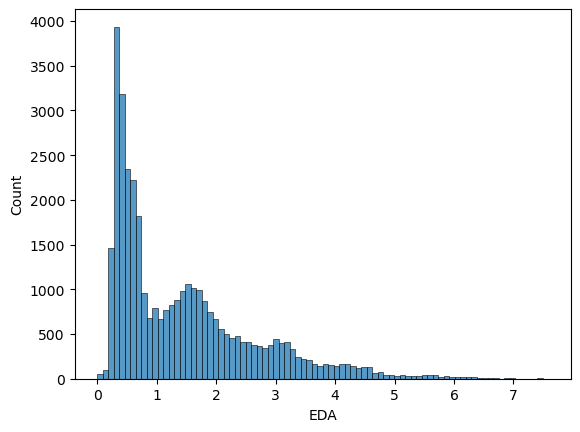

In [70]:
sns.histplot(np.sqrt(df["EDA"]))

In [5]:
models_dir = r"/Users/kuba/PycharmProjects/praca_lic/models" # REMEMBER TO CHAGE THIS PATH ON MAC

<Axes: xlabel='TEMP', ylabel='Count'>

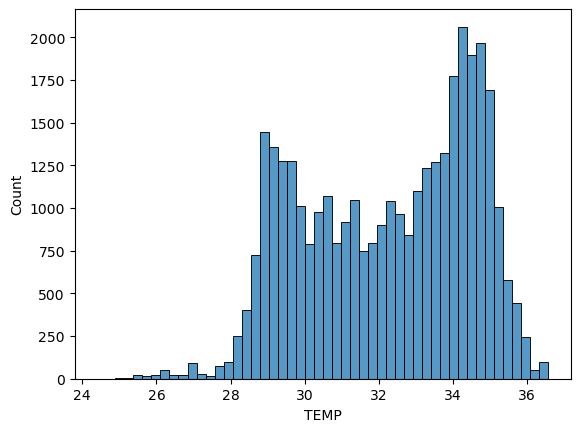

In [42]:
sns.histplot(df['TEMP'])

In [5]:
# === Partial Pooling - Heteroskedastic (Sigma ~ Stress, Varying by Nurse), one hot encoding, NON-CENTERED PARAMETRIZATION===
models_dir = r"c:\\repos\\praca_lic\\src" # REMEMBER TO CHAGE THIS PATH ON MAC
models = {}
idata = {}

for var in ["TEMP", "HR"]:
    print(f"---------------------{var} model---------------------")
    outcome = df[var].values   
    with pm.Model(coords=coords) as m_hier_sigma_dep_oh_reparam:
        # Hyperpriors for the common slopes
        mu_alpha = pm.Normal("mu_alpha", mu=df[var].mean(), sigma=0.5)
        sigma_alpha = pm.Exponential("sigma_alpha", 1.0)
        mu_beta_0 = pm.Normal("mu_beta_0", mu=0, sigma=1)  # Common slope for beta_0
        mu_beta_1 = pm.Normal("mu_beta_1", mu=0, sigma=1)  # Common slope for beta_1
        sigma_beta_0 = pm.Exponential("sigma_beta_0", 1.0)    
        sigma_beta_1 = pm.Exponential("sigma_beta_1", 1.0)
        
        # Group-level intercept
        alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, dims="nurse")
        
        # Varying slopes are now deviations from the common slopes (mu_beta_0 and mu_beta_1)
        beta_offset_0 = pm.Normal("beta_offset_0", mu=0, sigma=sigma_beta_0, dims="nurse")  # Deviation from mu_beta_0
        beta_offset_1 = pm.Normal("beta_offset_1", mu=0, sigma=sigma_beta_1, dims="nurse")  # Deviation from mu_beta_1
        
        # Varying slopes for each nurse are now defined as the common slope plus the deviation
        beta_0 = pm.Deterministic("beta_0", mu_beta_0 + beta_offset_0)
        beta_1 = pm.Deterministic("beta_1", mu_beta_1 + beta_offset_1)
        
        # Priors for the baseline log(sigma)
        mu_sigma_intercept = pm.Normal("mu_sigma_intercept", mu=0, sigma=1)

        # Priors for the effect of 'Niski/Średni' stress on log(sigma)
        mu_sigma_beta_0 = pm.Normal("mu_sigma_beta_0", mu=0, sigma=1)

        # Priors for the effect of 'Wysoki' stress on log(sigma)
        mu_sigma_beta_1 = pm.Normal("mu_sigma_beta_1", mu=0, sigma=1)

        # Model for log(sigma) depending on stress level (non-hierarchical)
        log_sigma = (
            mu_sigma_intercept
            + mu_sigma_beta_0 * df["label_Niski/Średni"].values
            + mu_sigma_beta_1 * df["label_Wysoki"].values
        )
        sigma = pm.Deterministic("sigma", pm.math.exp(log_sigma))
        
        # Model equation with varying intercepts and slopes
        mu = alpha[nurse_idx] + beta_0[nurse_idx] * df["label_Niski/Średni"].values + beta_1[nurse_idx] * df["label_Wysoki"].values

        if var == "TEMP":
            pm.Normal("y_obs", mu=mu, sigma=sigma, observed=outcome)
        if var == "EDA":
            alpha_skew = pm.Normal("alpha_skew", mu=0, sigma=5)
            pm.SkewNormal("y_obs", mu=mu, alpha=alpha_skew, sigma=sigma, observed=outcome)
        if var == "HR":
            nu = pm.Exponential("nu", 1)
            pm.StudentT("y_obs", mu=mu, nu=nu, sigma=sigma, observed=outcome)

        # Sampling with the reparameterized model
        # idata_hier_sigma_dep_nurse_reparam = pm.sample(2000, tune=2000, chains=4,
        #                                               cores=4, random_state=42, target_accept=0.9)
    
    models[var] = m_hier_sigma_dep_oh_reparam
    # idata[var] = idata_hier_sigma_dep_nurse_reparam

    # # az.plot_trace(idata_hier_sigma_dep_nurse, var_names = ["mu_alpha", "mu_beta_0", "mu_beta_1", "alpha", "beta_0", "beta_1"]); plt.tight_layout()
    # # plt.savefig(f"../reports/figures/trace_plots/{var}_m5_partial_pool_oh_sigma_dep_trace.png", bbox_inches="tight")       

    # # Prepare objects to save with cloudpickle
    # dict_to_save = {
    #     'model': m_hier_sigma_dep_oh_reparam,
    #     'idata': idata_hier_sigma_dep_nurse_reparam
    # }

    # # Save the dictionary using cloudpickle
    # pickle_filepath = os.path.join(models_dir, f"{var}_model_idata.pkl")
    # with open(pickle_filepath, 'wb') as buff:
    #     cloudpickle.dump(dict_to_save, buff)

    # print(f"Saved model and idata for {var} to {pickle_filepath}")

---------------------TEMP model---------------------
---------------------HR model---------------------


In [18]:
os.makedirs(models_dir, exist_ok=True)

# --------- Model and idata dictionaries ---------
model_objects = models

# Combine and save as one dict per variable
for var in model_objects:
    model = model_objects[var]
    idata = idatas[var]

    dict_to_save = {
        "model": model,
        "idata": idata
    }

    file_path = os.path.join(models_dir, f"{var}_model_idata.pkl")
    with open(file_path, "wb") as f:
        cloudpickle.dump(dict_to_save, f)
    print(f"✅ Saved: {file_path}")

# --------- Zip all .pkl files ---------
zip_path = os.path.join(models_dir, "pymc_models_combined.zip")
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for filename in os.listdir(models_dir):
        if filename.endswith(".pkl"):
            full_path = os.path.join(models_dir, filename)
            zipf.write(full_path, arcname=filename)
print(f"✅ All pickled models/idata zipped to: {zip_path}")


✅ Saved: /Users/kuba/PycharmProjects/praca_lic/models/TEMP_model_idata.pkl
✅ Saved: /Users/kuba/PycharmProjects/praca_lic/models/HR_model_idata.pkl
✅ All pickled models/idata zipped to: /Users/kuba/PycharmProjects/praca_lic/models/pymc_models_combined.zip


In [7]:
models_dir = "../models/"
vars = ["TEMP", "HR"]
idatas={}

for var in vars:
    idata_path = os.path.join(models_dir, f"{var}_idata.nc")
    model_path = os.path.join(models_dir, f"{var}_model.pkl")

    # Load idata from NetCDF (cross-platform safe!)
    idata = az.from_netcdf(idata_path)
    idatas[var] = idata

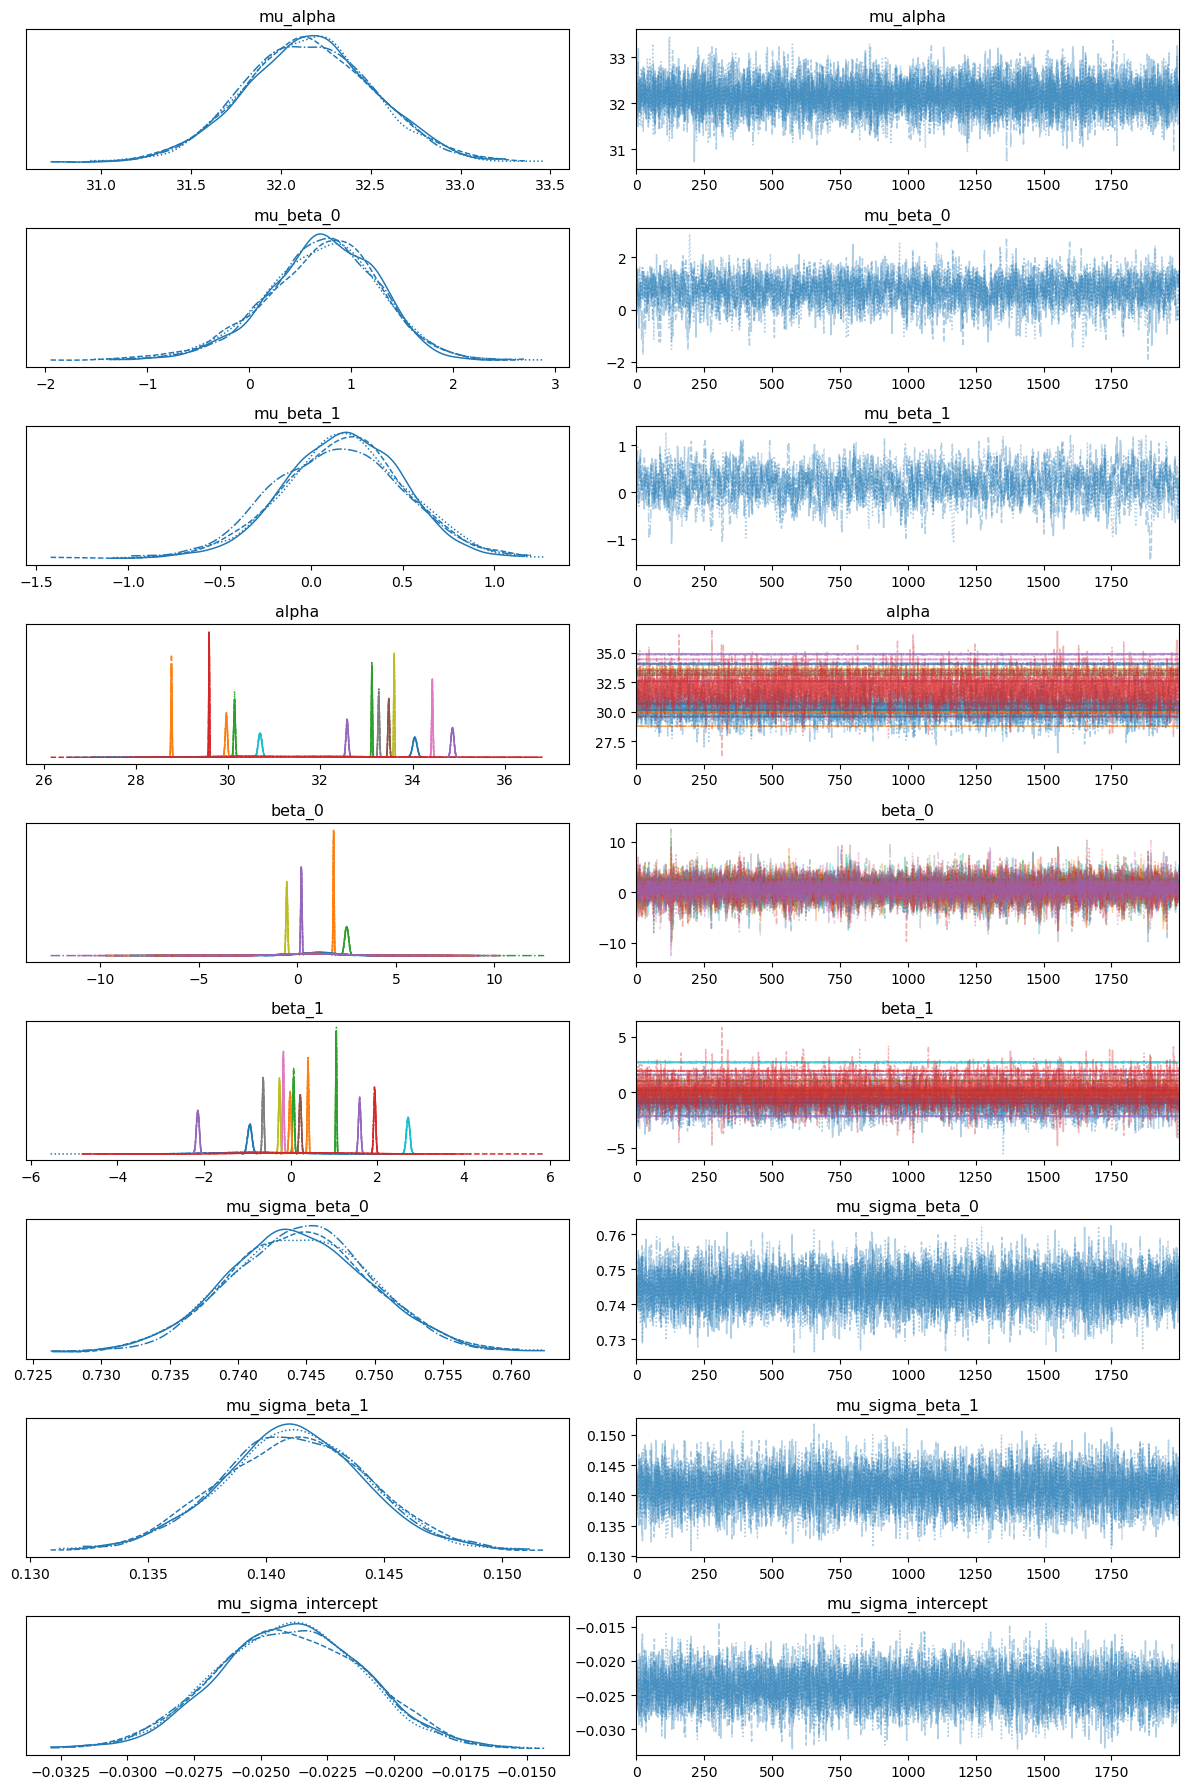

In [43]:
az.plot_trace(idatas["TEMP"], var_names = ["mu_alpha", "mu_beta_0", "mu_beta_1", "alpha", "beta_0", "beta_1", 
                                          "mu_sigma_beta_0", "mu_sigma_beta_1", "mu_sigma_intercept"]); plt.tight_layout()

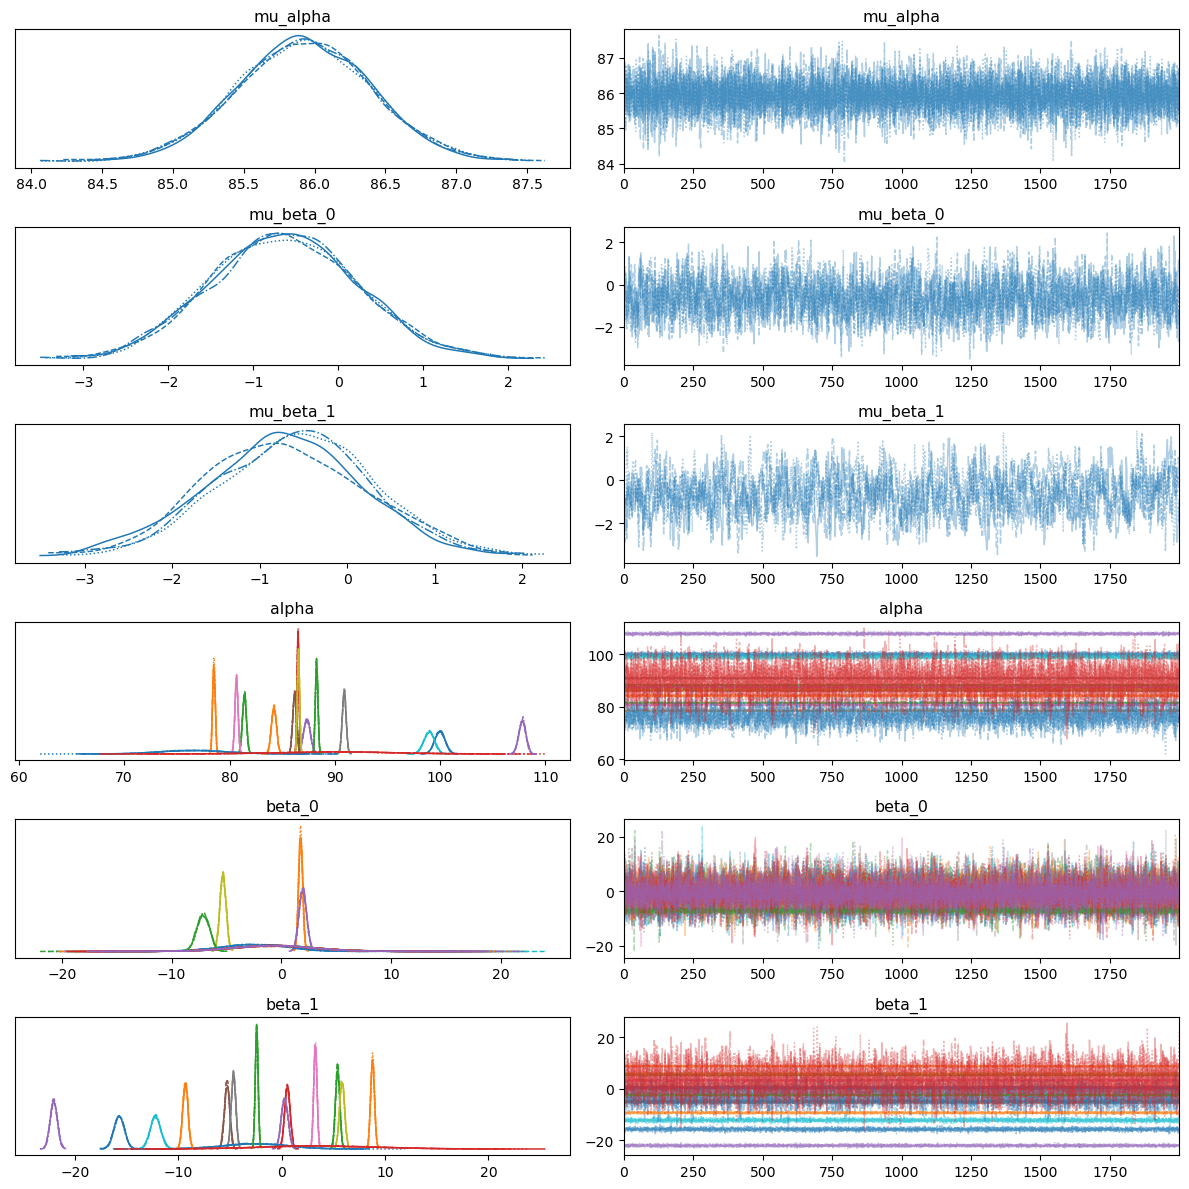

In [44]:
az.plot_trace(idatas["HR"], var_names = ["mu_alpha", "mu_beta_0", "mu_beta_1", "alpha", "beta_0", "beta_1"]); plt.tight_layout()

In [8]:
idatas["TEMP"]

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
az.summary(idatas['TEMP'], var_names = ["mu_alpha", "mu_beta_0", "mu_beta_1", "beta_0", "beta_1", "alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,32.155,0.360,31.480,32.838,0.003,0.005,14915.0,5588.0,1.0
mu_beta_0,0.708,0.566,-0.357,1.753,0.012,0.009,2389.0,2617.0,1.0
mu_beta_1,0.170,0.345,-0.463,0.832,0.010,0.007,1148.0,1654.0,1.0
beta_0[0],0.687,1.613,-2.464,3.658,0.019,0.029,7899.0,4308.0,1.0
beta_0[1],1.839,0.024,1.790,1.881,0.000,0.000,8387.0,6347.0,1.0
beta_0[2],0.727,1.619,-2.342,3.720,0.019,0.028,7465.0,4528.0,1.0
beta_0[3],0.717,1.610,-2.357,3.745,0.021,0.029,6299.0,4295.0,1.0
beta_0[4],0.202,0.032,0.143,0.263,0.000,0.000,11925.0,6819.0,1.0
beta_0[5],0.722,1.659,-2.608,3.671,0.021,0.030,7245.0,4624.0,1.0
beta_0[6],0.709,1.627,-2.297,3.801,0.021,0.033,7154.0,4057.0,1.0
